In [32]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import symbol as s
import seaborn as sns
from sklearn.preprocessing import scale

sns.set_style("dark")

%matplotlib inline

In [3]:
port = s.Portifolio(index='nifty_500', start=2010, null_count=5, volume=1000, benchmark='nifty_50')
len(port.symbol_list)

294

In [4]:
hdata = port.get_symbol_hist()
hret = port.get_symbol_returns().interpolate(limit=5)
iret = port.get_index_returns()
hret = hret.dropna(axis=1)
scaled_hret = pd.DataFrame(scale(hret), columns=hret.columns.copy(), index=hret.index.copy())
hclose = port.get_symbol_close()
pref_symbols = hclose.columns[hclose.ix[-1, :] <= 1000]
pref_symbols = pref_symbols.intersection(hret.columns)
hret = hret[pref_symbols]
hclose = hclose[pref_symbols]
len(hret), len(hret.columns), len(iret)

(1732, 246, 1729)

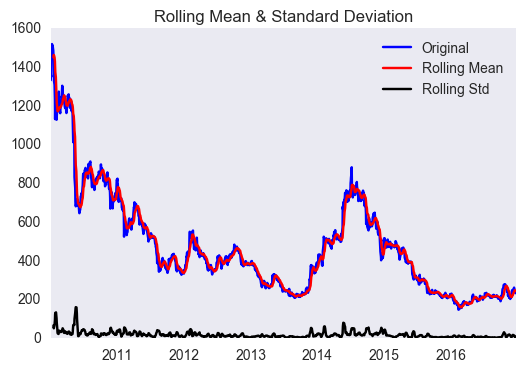

Results of Dickey-Fuller Test:
Test Statistic                   -4.237124
p-value                           0.000570
#Lags Used                        7.000000
Number of Observations Used    1724.000000
Critical Value (1%)              -3.434149
Critical Value (10%)             -2.567663
Critical Value (5%)              -2.863218
dtype: float64


In [35]:
ts = hclose.aban
test_stationarity(ts)

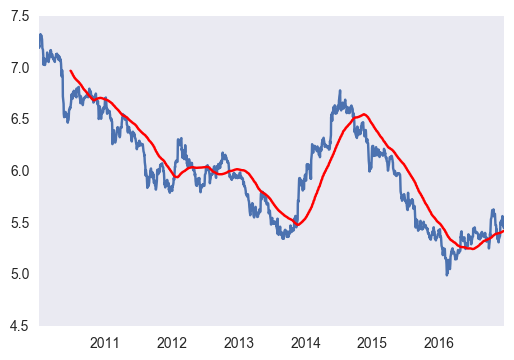

In [51]:
ts_log = np.log(ts)
# ts_log.plot()
moving_avg = ts_log.rolling(120).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [52]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)

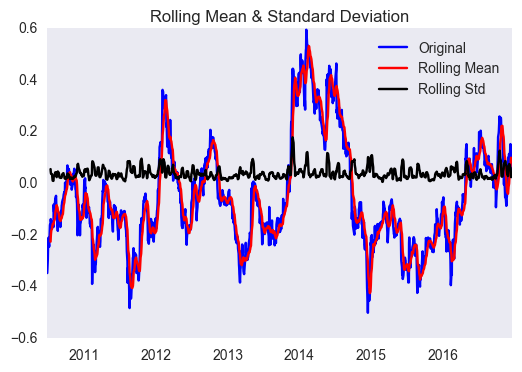

Results of Dickey-Fuller Test:
Test Statistic                   -3.085113
p-value                           0.027675
#Lags Used                        4.000000
Number of Observations Used    1608.000000
Critical Value (1%)              -3.434423
Critical Value (10%)             -2.567728
Critical Value (5%)              -2.863339
dtype: float64


In [53]:
test_stationarity(ts_log_moving_avg_diff)

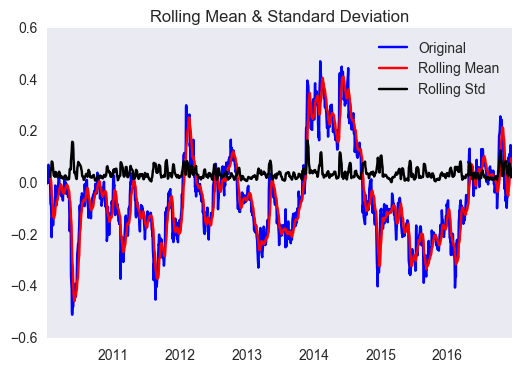

Results of Dickey-Fuller Test:
Test Statistic                   -3.738574
p-value                           0.003602
#Lags Used                        4.000000
Number of Observations Used    1727.000000
Critical Value (1%)              -3.434142
Critical Value (10%)             -2.567662
Critical Value (5%)              -2.863215
dtype: float64


In [60]:
expwighted_avg = ts_log.ewm(halflife=40).mean()
# plt.plot(ts_log)
# plt.plot(expwighted_avg, color='red')
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

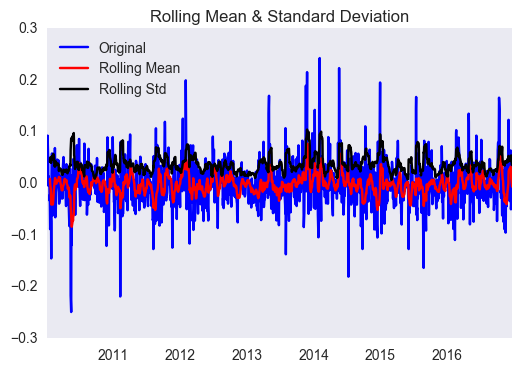

Results of Dickey-Fuller Test:
Test Statistic                -9.156877e+00
p-value                        2.595468e-15
#Lags Used                     2.100000e+01
Number of Observations Used    1.708000e+03
Critical Value (1%)           -3.434184e+00
Critical Value (10%)          -2.567672e+00
Critical Value (5%)           -2.863234e+00
dtype: float64


In [77]:
ts_log_diff = ts_log - ts_log.shift(2)
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

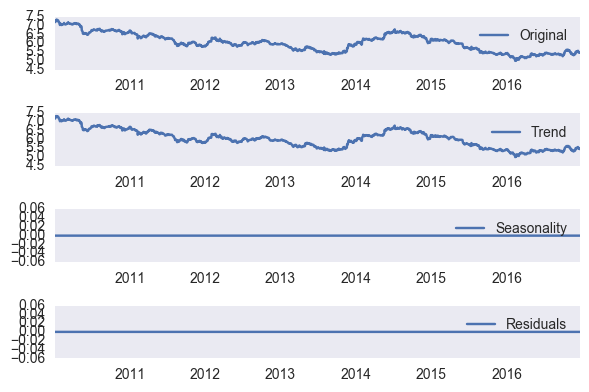

In [71]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, freq=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

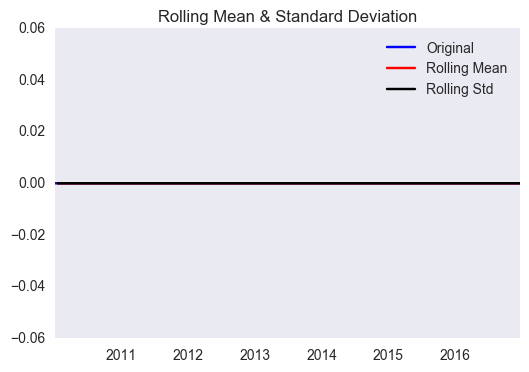

Results of Dickey-Fuller Test:
Test Statistic                         NaN
p-value                                NaN
#Lags Used                        0.000000
Number of Observations Used    1731.000000
Critical Value (1%)              -3.434133
Critical Value (10%)             -2.567660
Critical Value (5%)              -2.863211
dtype: float64


C:\Users\Akash\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:712: RuntimeWarning: divide by zero encountered in log
  (self.endog - np.dot(self.exog,params)))) -\
C:\Users\Akash\Anaconda3\lib\site-packages\statsmodels\base\model.py:978: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Akash\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Akash\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Akash\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1731: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


In [70]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

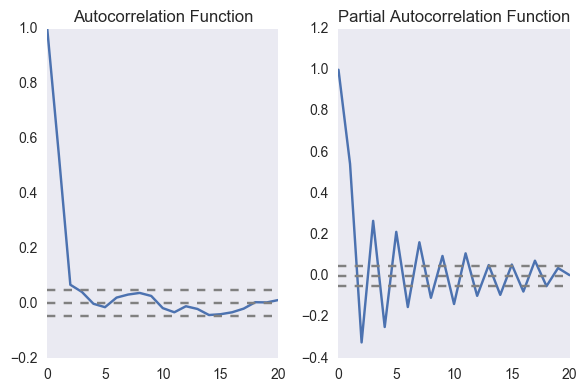

In [79]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

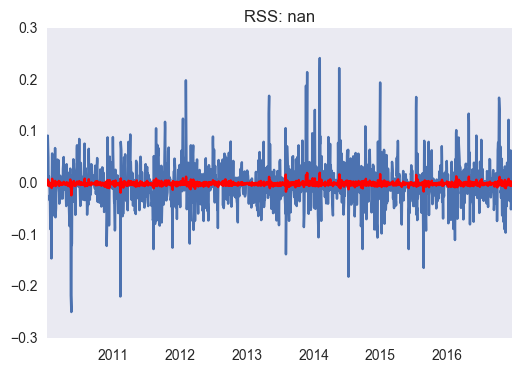

In [80]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

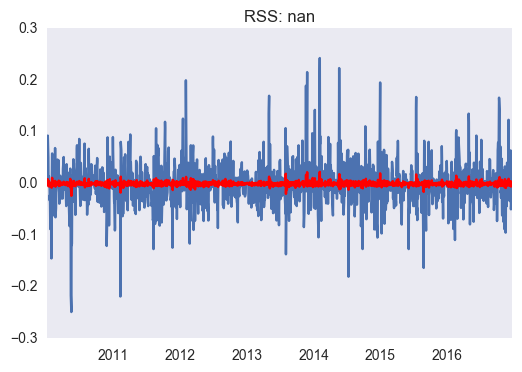

In [81]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

C:\Users\Akash\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


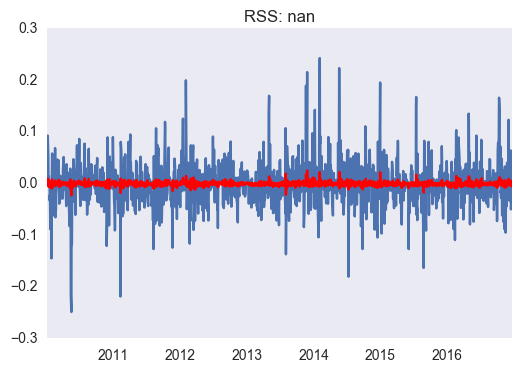

In [82]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [86]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

date
2010-01-05   -0.000983
2010-01-06    0.000546
2010-01-07   -0.002100
2010-01-08    0.006906
2010-01-11    0.005310
dtype: float64

In [87]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

date
2010-01-04    7.194512
2010-01-05    7.193529
2010-01-06    7.195058
2010-01-07    7.192412
2010-01-08    7.201418
dtype: float64

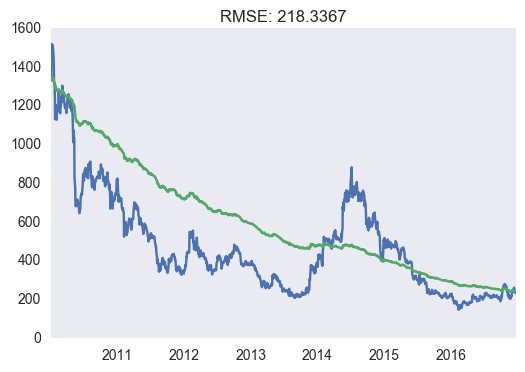

In [88]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))